In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.algorithms.minimum_eigen_solvers.qaoa import QAOAAnsatz

from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram
from qiskit.visualization import plot_histogram
from typing import List, Tuple
from qiskit.visualization import plot_histogram,plot_bloch_multivector,array_to_latex
from operator import itemgetter
from qiskit_optimization.applications import Maxcut 
from collections import defaultdict
from qiskit.result import QuasiDistribution
from qiskit.quantum_info import Pauli, Statevector
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, CplexOptimizer
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit_optimization.problems.variable import VarType
import copy
from docplex.mp.model import Model

In [2]:
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

Insert the graph representing the problem instance

In [3]:
g1 = nx.Graph()
g1.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])

g2 = nx.Graph()
g2.add_nodes_from([0, 1, 2, 3])
g2.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

graph_ring7 =  nx.Graph()
graph_ring7.add_nodes_from([0, 1, 2, 3,4 ,5, 6])
graph_ring7.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5),(5, 6), (6, 0)])

graph_bin_tree = nx.Graph()
graph_bin_tree.add_nodes_from([0, 1, 2, 3, 4, 5, 6])
graph_bin_tree.add_edges_from([(0, 1), (0, 2), (1, 3),(1, 4), (2, 5), (2, 6)])

pos = None

#nx.bipartite_layout(G, [0,1,2])

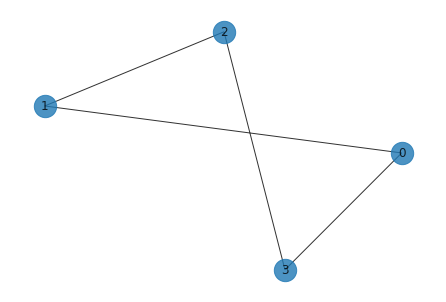

In [4]:
G = g2

nx.draw(G, with_labels=True, alpha=0.8, node_size=500, pos=pos)

In [5]:
#We can get the quadratic program from the graph mannualy

def get_quadratic_program(G):
    """Generate Hamiltonian for the max-cut problem of a graph
    """
    n_qubits = len(G.nodes())
    problem = QuadraticProgram()
    _ = [problem.binary_var("x{}".format(i)) for i in range(n_qubits)]
    problem.maximize(
        linear=nx.adjacency_matrix(G).dot(np.ones(n_qubits)),
        quadratic=-nx.adjacency_matrix(G),
    )
    return problem

    

It is more convenient to get the quadratic program using qiskit_optimization MaxCut class

In [6]:
max_cut = Maxcut(G)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 2*x_0 + 2*x_1 + 2*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



With this we can already convert this problem to an Ising Hamiltonian in the SparsePauliOp() format

In [7]:
C, offset = qp.to_ising()
print(C)
print(offset)

0.5 * IIZZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII
-2.0


We can use the QAOAAnsatz from qiksit.circuit_library to quickly construct the circuit for p=1

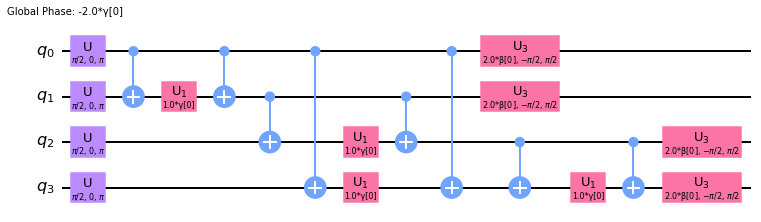

In [8]:
p = 1 #number of layers

ansatz = QAOAAnsatz(C, p).decompose(reps = 5)

ansatz.draw('mpl')

Now we implemen the QAOA usign Qikit_optimization

In [9]:

p = 1

test_values = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
one_list = [1 for i in range(0,2*p)]
parameter_list = one_list

algorithm_globals.random_seed = 10598

qaoa_mes = QAOA(sampler=Sampler(), optimizer=COBYLA(), initial_point=parameter_list, reps=p)
exact_mes = NumPyMinimumEigensolver()  


To run QAOA directy from the QAOA class (qiskit.algorithms.minimum_eigensolvers) we must pass the problem as an Ising operator

In [10]:
res = qaoa_mes.compute_minimum_eigenvalue(C)

The result is an intance of SamplingVQEResult

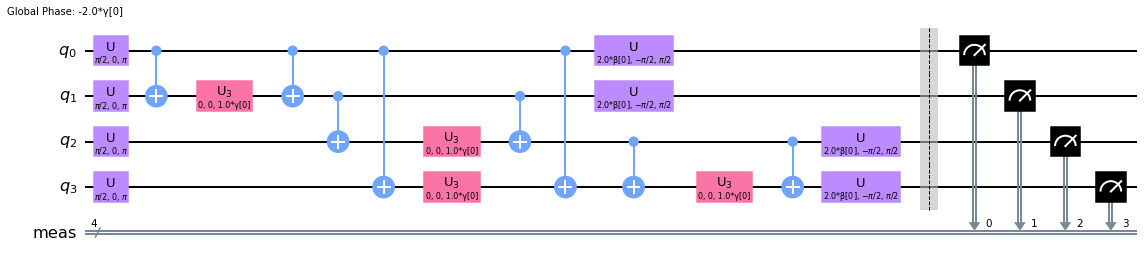

In [11]:
res.optimal_circuit.decompose(reps=5).draw('mpl')

We can get the optimal parameters and other information directly from the QAOA class

In [12]:
res.optimal_parameters

{ParameterVectorElement(β[0]): 1.1781504946146368,
 ParameterVectorElement(γ[0]): 0.7854805051885432}

In [13]:
res.optimal_point

array([1.17815049, 0.78548051])

In [14]:
res.optimizer_time

0.753833532333374

In [15]:
res.eigenstate

{0: 0.015623491304748,
 1: 0.0156198561887073,
 2: 0.0156198561887073,
 3: 0.0781368008483912,
 4: 0.0156198561887073,
 5: 0.2656234822436404,
 6: 0.0781368008483912,
 7: 0.0156198561887073,
 8: 0.0156198561887073,
 9: 0.0781368008483912,
 10: 0.2656234822436404,
 11: 0.0156198561887073,
 12: 0.0781368008483912,
 13: 0.0156198561887073,
 14: 0.0156198561887073,
 15: 0.015623491304748}

In [16]:
display(res.best_measurement)
display(res.eigenvalue)
display(res.best_measurement['bitstring'])

{'state': 5,
 'bitstring': '0101',
 'value': (-2+0j),
 'probability': 0.268418375977081}

-0.9999999637555698

'0101'

We can instead use qiskit_optimization MiminumEigenOptimizer wrapper

In [17]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solverqaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA


In [18]:
exact_result = exact.solve(qp) #Solving usign classical NumpyMinimunEigensolver
print(exact_result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


In [19]:
qaoa_result = qaoa.solve(qp) #Solving with QAOA
print(qaoa_result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


Now the result is an instance of MinimumEigenOptimizationResult

In [20]:
qaoa_result.x

array([1., 0., 1., 0.])

In [21]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (OptimizationResultStatus.SUCCESS,),
):
    """ Filters the samples for which the optimization failed or the probability is below some threshhold"""
    res = []
    for s in samples:
        if s.status in allowed_status and s.probability > threshold:
            res.append(s)

    return res

In [22]:
filtered_samples = get_filtered_samples(
    qaoa_result.samples, threshold=0.005, allowed_status=(OptimizationResultStatus.SUCCESS,)
)
for s in filtered_samples:
    print(s)

SolutionSample(x=array([1., 0., 1., 0.]), fval=4.0, probability=0.2656234822436404, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0., 1.]), fval=4.0, probability=0.2656234822436404, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0., 0.]), fval=2.0, probability=0.0156198561887073, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 0., 0.]), fval=2.0, probability=0.0156198561887073, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0., 0.]), fval=2.0, probability=0.0781368008483912, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1., 0.]), fval=2.0, probability=0.0156198561887073, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1., 0.]), fval=2.0, probability=0.0781368008483912, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1., 0.]), fval=2.0, probability=0.0156198561887073, status

In [23]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]

#We compute the average and standart deviation for the cost function value
print(np.mean(fvals))
print(np.std(fvals))

2.0
1.0


In [24]:
samples_for_plot = {''.join('{}'.format(int(s.x[i])) for i in range(len(s.x))):s.probability for s in filtered_samples}
samples_for_plot

{'1010': 0.2656234822436404,
 '0101': 0.2656234822436404,
 '1000': 0.0156198561887073,
 '0100': 0.0156198561887073,
 '1100': 0.0781368008483912,
 '0010': 0.0156198561887073,
 '0110': 0.0781368008483912,
 '1110': 0.0156198561887073,
 '0001': 0.0156198561887073,
 '1001': 0.0781368008483912,
 '1101': 0.0156198561887073,
 '0011': 0.0781368008483912,
 '1011': 0.0156198561887073,
 '0111': 0.0156198561887073,
 '0000': 0.015623491304748,
 '1111': 0.015623491304748}

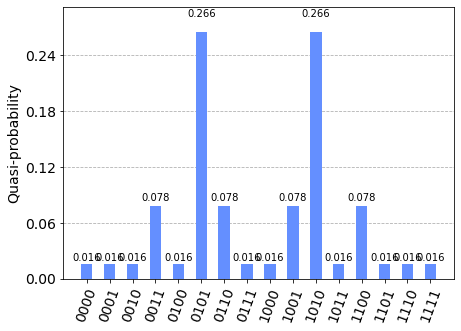

In [25]:
plot_histogram(samples_for_plot)

We can also get a histogram for the values of the objective function

<BarContainer object of 3 artists>

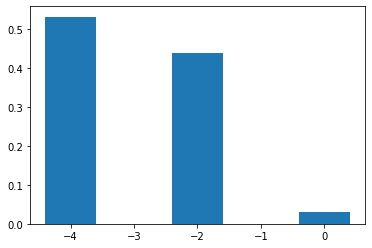

In [26]:
energies = defaultdict(int)
for k, v in samples_for_plot.items():
    energies[maxcut_obj(k,G)] += v

x,y = zip(*energies.items())
plt.bar(x,y)

We can verifiy the answer by brute force 

Best string: 1010 with cut: 4


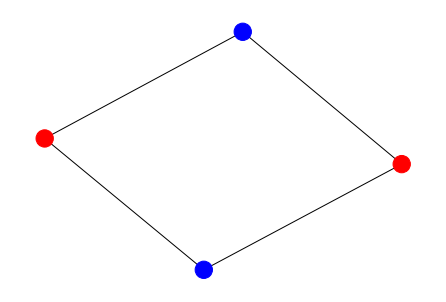

In [27]:

# get the best solution:

best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in samples_for_plot.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=pos)

It matches!

Let's compare the perfomance with the warm start QAOA

In [28]:
qp.prettyprint()
qaoa_mes

In [29]:
WarmStartQAOAOptimizer(pre_solver = CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes )